In [2]:
!pip install geopandas pandas matplotlib numpy seaborn

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns

### Concordância das revisões 

In [4]:
first_annotations = pd.read_csv('./data/annotated/first_annotations/data_first_annotations.csv')
first_annotations.columns

Index(['video_url', 'brazilian_state', 'corrected_transcription',
       'text_origin', 'specific_contexts', 'punchlines', 'joke_explanation',
       'fun', 'humor', 'nonsense', 'wit', 'irony', 'satire', 'sarcasm',
       'cynicism'],
      dtype='object')

In [5]:
data_with_comments = pd.read_csv('./data/annotated/annotated_data_with_reviewers_comments/data_annotation_with_peer_review_comments.csv')
data_with_comments.columns

Index(['video_url', 'brazilian_state', 'corrected_transcription',
       'text_origin', 'specific_contexts',
       'Os contextos específicos fornecidos fazem sentido? Alguma outra explicação poderia ser incluída?',
       'punchlines',
       'Os trechos selecionados realmente contribuem para a comicidade do texto? Há algum outro trecho que caiba ser destacado?',
       'joke_explanation',
       'A explicação está clara e bem fundamentada? Está coerente com os elementos do texto? De fato é isso que torna o texto engraçado? Que outra ideia poderia ser explicada?',
       'fun', 'humor', 'nonsense', 'wit', 'irony', 'satire', 'sarcasm',
       'cynicism',
       'Os estilos cômicos atribuídos fazem sentido? Algum outro estilo deveria ser incluído?',
       'Algum estilo cômico deveria ser removido?', 'annotator_ID'],
      dtype='object')

In [6]:
data_new_annotations_from_review = pd.read_csv('./data/annotated/new_annotations_from_review_comments/data_with_new_annotation_from_peer_review_comments.csv')
data_new_annotations_from_review.columns

Index(['video_url', 'brazilian_state', 'corrected_transcription',
       'text_origin', 'specific_contexts',
       'Os contextos específicos fornecidos fazem sentido? Alguma outra explicação poderia ser incluída?',
       'punchlines',
       'Os trechos selecionados realmente contribuem para a comicidade do texto? Há algum outro trecho que caiba ser destacado?',
       'joke_explanation',
       'A explicação está clara e bem fundamentada? Está coerente com os elementos do texto? De fato é isso que torna o texto engraçado? Que outra ideia poderia ser explicada?',
       'fun', 'humor', 'nonsense', 'wit', 'irony', 'satire', 'sarcasm',
       'cynicism',
       'Os estilos cômicos atribuídos fazem sentido? Algum outro estilo deveria ser incluído?',
       'Algum estilo cômico deveria ser removido?', 'annotator_ID'],
      dtype='object')

#### Quantidade de sugestões por tarefas

In [23]:
styles_removal_suggestions_count = data_with_comments['Algum estilo cômico deveria ser removido?'].value_counts().sum()
specific_contexts = data_with_comments['Os contextos específicos fornecidos fazem sentido? Alguma outra explicação poderia ser incluída?'].value_counts().sum()
styles_inclusion_suggestions_count = data_with_comments['Os estilos cômicos atribuídos fazem sentido? Algum outro estilo deveria ser incluído?'].value_counts().sum()
punchlines_suggestions_count = data_with_comments['Os trechos selecionados realmente contribuem para a comicidade do texto? Há algum outro trecho que caiba ser destacado?'].value_counts().sum()
explanations_suggestions_count = data_with_comments['A explicação está clara e bem fundamentada? Está coerente com os elementos do texto? De fato é isso que torna o texto engraçado? Que outra ideia poderia ser explicada?'].value_counts().sum()

In [31]:
print(f'Sugestões de explicações: {explanations_suggestions_count}/{len(data_with_comments)} -> {explanations_suggestions_count/len(data_with_comments)* 100}')
print(f'Sugestões de punchlines: {punchlines_suggestions_count} -> {punchlines_suggestions_count/len(data_with_comments)* 100}')
print(f'Sugestões de inclusão de estilos: {styles_inclusion_suggestions_count} -> {styles_inclusion_suggestions_count/len(data_with_comments)* 100}')
print(f'Sugestões de remoção de estilos: {styles_removal_suggestions_count} -> {styles_removal_suggestions_count/len(data_with_comments)* 100}')

Sugestões de explicações: 9/475 -> 1.8947368421052633
Sugestões de punchlines: 5 -> 1.0526315789473684
Sugestões de inclusão de estilos: 81 -> 17.05263157894737
Sugestões de remoção de estilos: 42 -> 8.842105263157894


#### Quantidade de diferenças após as anotações

In [13]:
first_annotations.columns

Index(['video_url', 'brazilian_state', 'corrected_transcription',
       'text_origin', 'specific_contexts', 'punchlines', 'joke_explanation',
       'fun', 'humor', 'nonsense', 'wit', 'irony', 'satire', 'sarcasm',
       'cynicism'],
      dtype='object')

In [38]:
# Define as colunas relevantes
cols = ['fun', 'humor', 'nonsense', 'wit', 'irony', 'satire', 'sarcasm', 'cynicism']

# Garante que os dois DataFrames estão indexados por video_url
first = first_annotations.set_index('video_url')[cols]
second = data_new_annotations_from_review.set_index('video_url')[cols]

# Faz o alinhamento automático por video_url
first, second = first.align(second, join='inner', axis=0)  # só os IDs em comum

# Cria máscara de diferenças
diff_mask = (first != second)

# Conta quantas células mudaram por coluna
changes_per_column = diff_mask.sum(axis=0)/475*100

print("Número de células modificadas por coluna:")
print(changes_per_column)

# Se quiser o total geral:
total_changed_cells = diff_mask.values.sum()
print(f"\nTotal de células modificadas: {total_changed_cells}")

Número de células modificadas por coluna:
fun         1.684211
humor       2.315789
nonsense    4.000000
wit         4.842105
irony       4.631579
satire      4.421053
sarcasm     3.578947
cynicism    2.947368
dtype: float64

Total de células modificadas: 135


In [32]:
text_cols = ['punchlines', 'joke_explanation', 'corrected_transcription', 'specific_contexts']

first = first_annotations.set_index('video_url')[text_cols]
second = data_new_annotations_from_review.set_index('video_url')[text_cols]
first, second = first.align(second, join='inner', axis=0)

def count_word_diff(a, b):
    if pd.isna(a) or pd.isna(b):
        return 0
    return len(str(b).strip().split()) - len(str(a).strip().split())

def count_char_diff(a, b):
    if pd.isna(a) or pd.isna(b):
        return 0
    return len(str(b).strip()) - len(str(a).strip())

# Contagem de palavras e caracteres antes/depois
word_count_first = first.applymap(lambda x: len(str(x).strip().split()) if pd.notna(x) else 0)
word_count_second = second.applymap(lambda x: len(str(x).strip().split()) if pd.notna(x) else 0)
char_count_first = first.applymap(lambda x: len(str(x).strip()) if pd.notna(x) else 0)
char_count_second = second.applymap(lambda x: len(str(x).strip()) if pd.notna(x) else 0)

# Diferença (como antes)
word_diffs = word_count_second - word_count_first
char_diffs = char_count_second - char_count_first

# Totais
old_word_sum = word_count_first.sum()
new_word_sum = word_count_second.sum()
word_diff_sum = word_diffs.sum()

old_char_sum = char_count_first.sum()
new_char_sum = char_count_second.sum()
char_diff_sum = char_diffs.sum()

# Percentual de aumento
percent_increase_words = ((new_word_sum - old_word_sum) / old_word_sum * 100).round(2)
percent_increase_chars = ((new_char_sum - old_char_sum) / old_char_sum * 100).round(2)

# Prints organizados
print("=== Estatísticas de PALAVRAS ===")
for col in text_cols:
    print(f"\nColuna: {col}")
    print(f"  Total anterior: {old_word_sum[col]}")
    print(f"  Total atual:    {new_word_sum[col]}")
    print(f"  Diferença:      {word_diff_sum[col]:+}")
    print(f"  Percentual:     {percent_increase_words[col]}%")

print("\n=== Estatísticas de CARACTERES ===")
for col in text_cols:
    print(f"\nColuna: {col}")
    print(f"  Total anterior: {old_char_sum[col]}")
    print(f"  Total atual:    {new_char_sum[col]}")
    print(f"  Diferença:      {char_diff_sum[col]:+}")
    print(f"  Percentual:     {percent_increase_chars[col]}%")

=== Estatísticas de PALAVRAS ===

Coluna: punchlines
  Total anterior: 16165
  Total atual:    16375
  Diferença:      +210
  Percentual:     1.3%

Coluna: joke_explanation
  Total anterior: 26548
  Total atual:    26765
  Diferença:      +217
  Percentual:     0.82%

Coluna: corrected_transcription
  Total anterior: 54840
  Total atual:    55821
  Diferença:      +981
  Percentual:     1.79%

Coluna: specific_contexts
  Total anterior: 2989
  Total atual:    4082
  Diferença:      +1093
  Percentual:     36.57%

=== Estatísticas de CARACTERES ===

Coluna: punchlines
  Total anterior: 85137
  Total atual:    86445
  Diferença:      +1308
  Percentual:     1.54%

Coluna: joke_explanation
  Total anterior: 155444
  Total atual:    156795
  Diferença:      +1351
  Percentual:     0.87%

Coluna: corrected_transcription
  Total anterior: 288077
  Total atual:    297068
  Diferença:      +8991
  Percentual:     3.12%

Coluna: specific_contexts
  Total anterior: 18475
  Total atual:    25024


/tmp/ipykernel_62625/338065687.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  word_count_first = first.applymap(lambda x: len(str(x).strip().split()) if pd.notna(x) else 0)
/tmp/ipykernel_62625/338065687.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  word_count_second = second.applymap(lambda x: len(str(x).strip().split()) if pd.notna(x) else 0)
/tmp/ipykernel_62625/338065687.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  char_count_first = first.applymap(lambda x: len(str(x).strip()) if pd.notna(x) else 0)
/tmp/ipykernel_62625/338065687.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  char_count_second = second.applymap(lambda x: len(str(x).strip()) if pd.notna(x) else 0)


### Distribuições

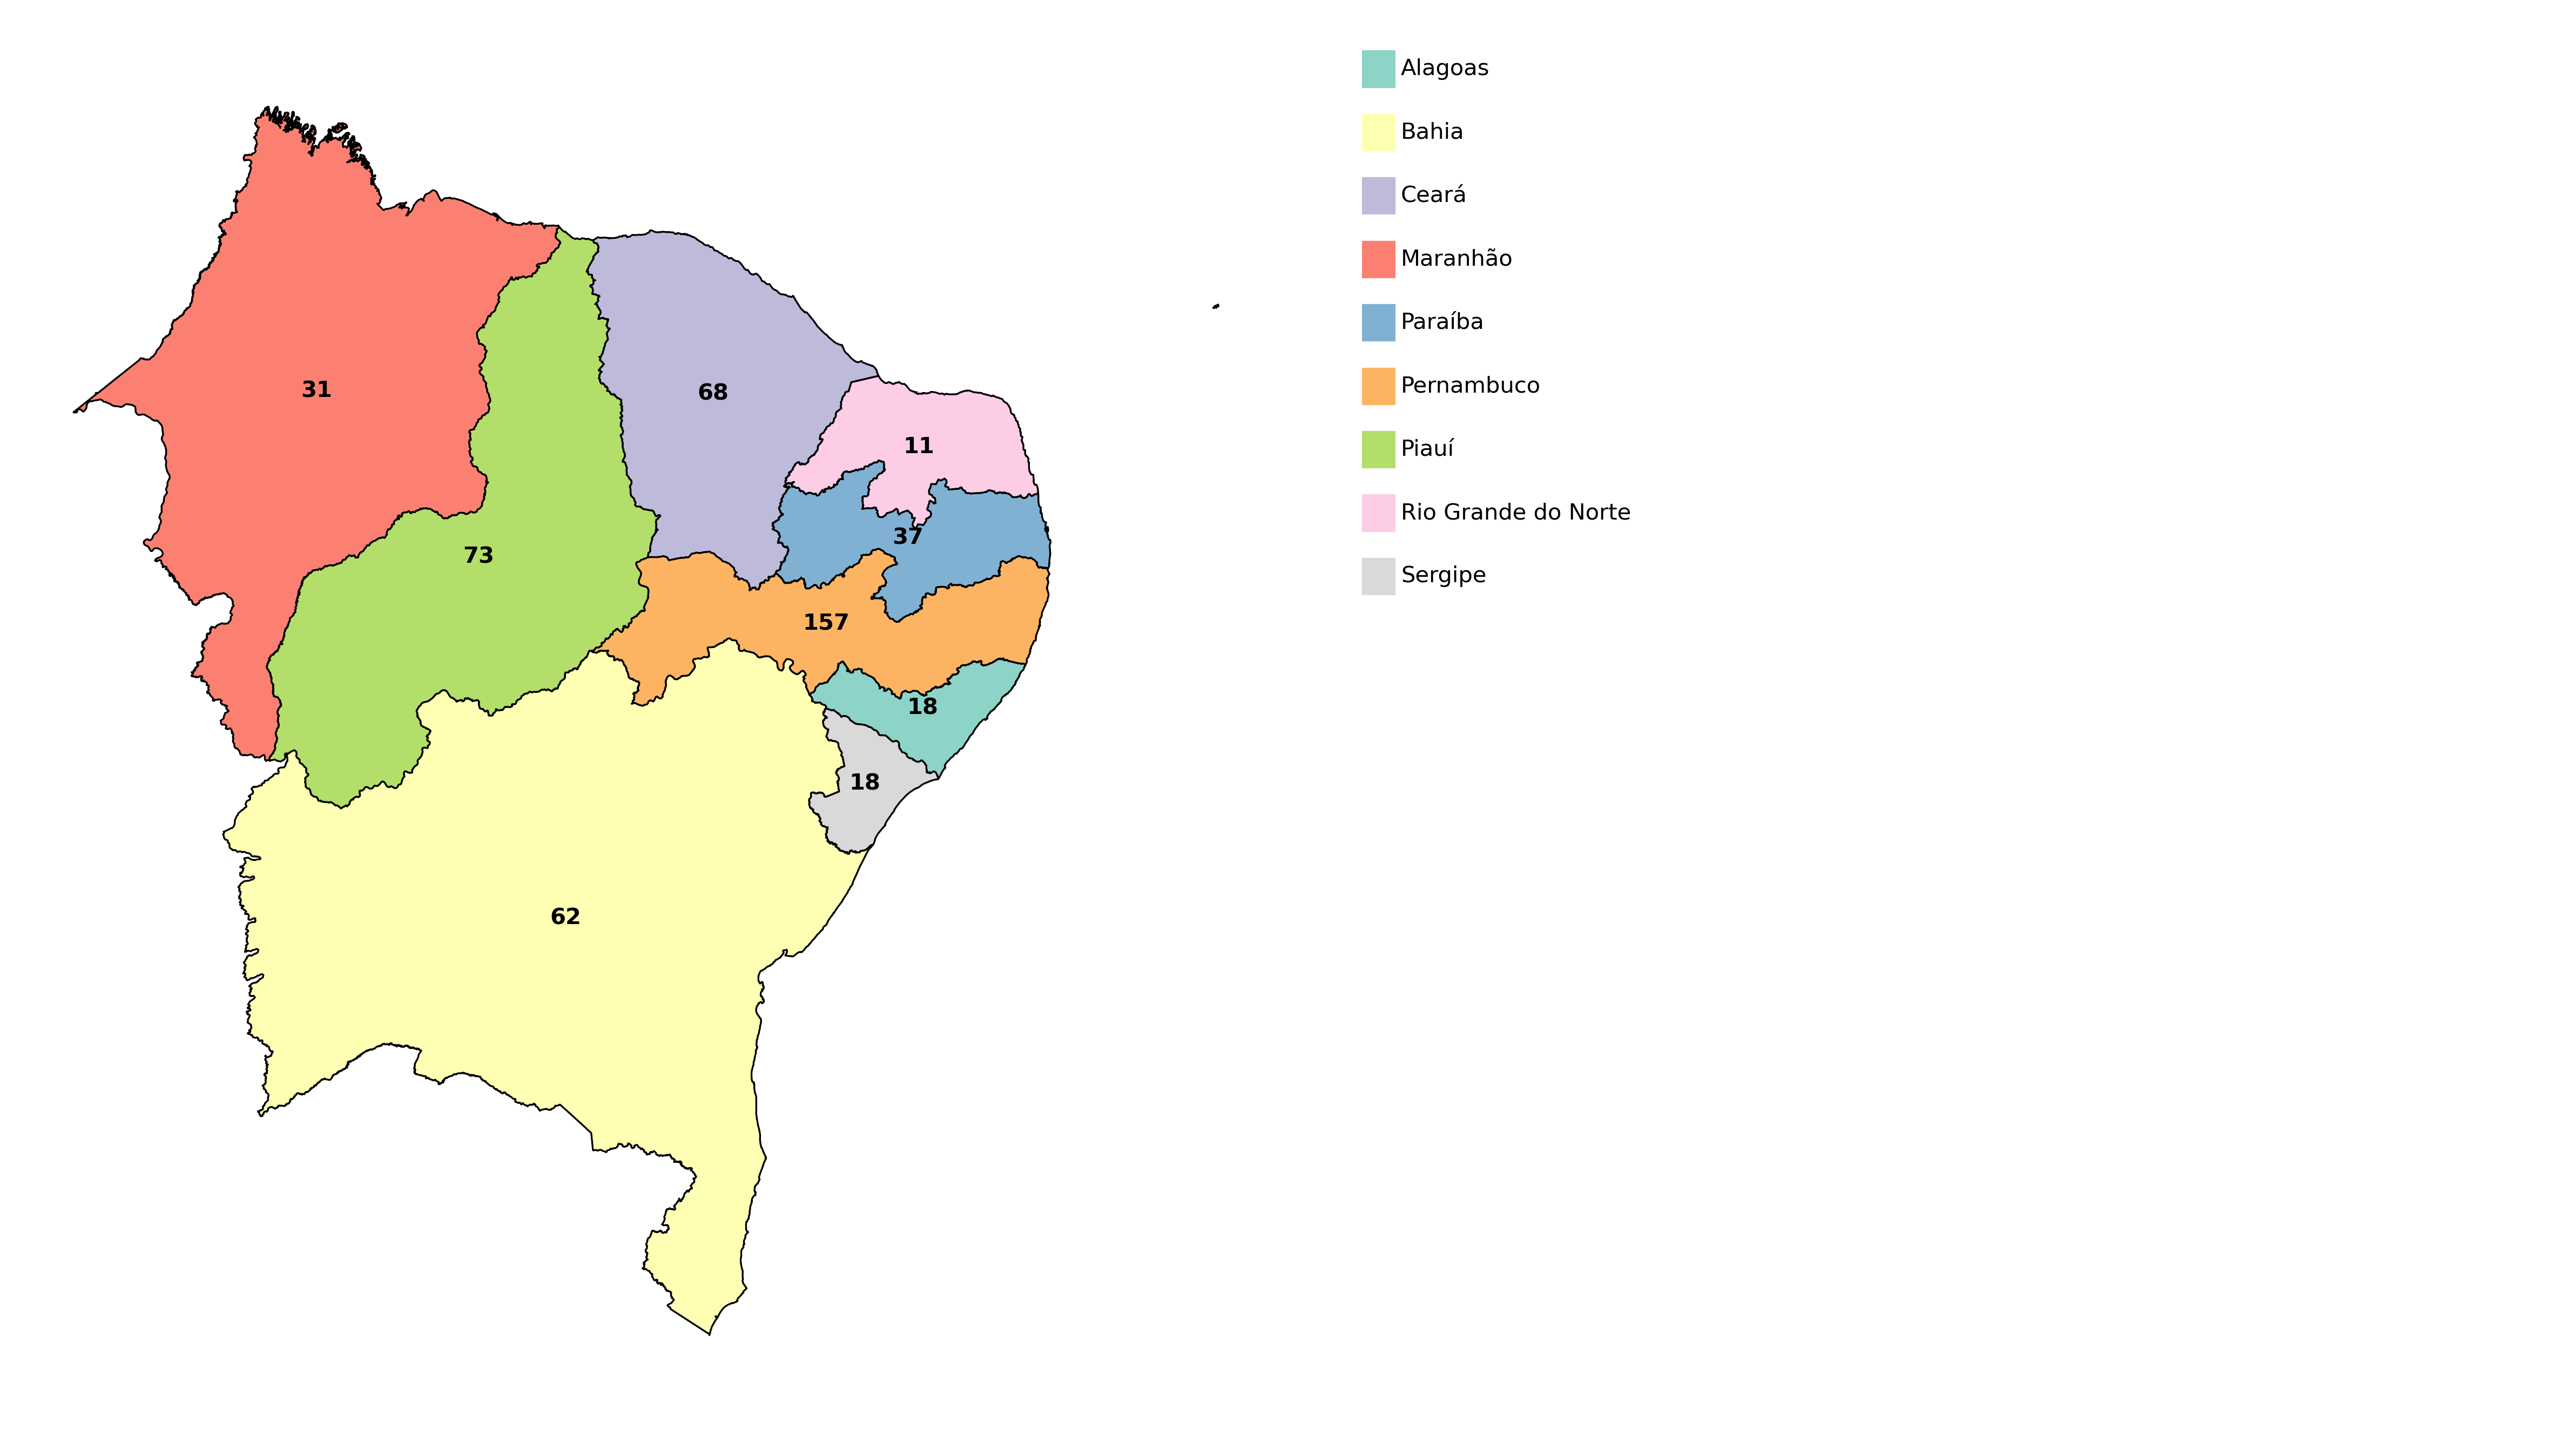

In [16]:
df = pd.read_csv('./data/completed/brazilian_ne_annotated_humorous_texts.csv')

state_counts = df['brazilian_state'].value_counts().reset_index()
state_counts.columns = ['brazilian_state', 'annotation_count']

northeast_states = [
    'Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba',
    'Pernambuco', 'Piauí', 'Rio Grande do Norte', 'Sergipe'
]

state_counts = state_counts[state_counts['brazilian_state'].isin(northeast_states)]

states = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')

northeast_map = states[states['name'].isin(northeast_states)].copy()

northeast_map = northeast_map.merge(state_counts, left_on='name', right_on='brazilian_state')

palette = sns.color_palette("Set3", len(northeast_map))
state_colors = {state: mcolors.to_hex(palette[i]) for i, state in enumerate(northeast_map['name'])}
northeast_map['color'] = northeast_map['name'].map(state_colors)

fig, ax = plt.subplots(1, 2, figsize=(16, 9), dpi = 300)

northeast_map.plot(
    ax=ax[0],
    color=northeast_map['color'],
    edgecolor='black',
    linewidth=0.8
)

for idx, row in northeast_map.iterrows():
    centroid = row['geometry'].centroid
    ax[0].text(centroid.x, centroid.y, str(row['annotation_count']),
               fontsize=10, ha='center', va='center', color='black', weight='bold')

ax[0].axis('off')
ax[1].axis('off')
legend_table = pd.DataFrame({
    'State': northeast_map['name'],
    'Color': northeast_map['color']
}).sort_values('State').reset_index(drop=True)

box_width = 0.025
box_height = 0.025
start_y = 0.95
line_spacing = 0.045

for i, row in legend_table.iterrows():
    y = start_y - i * line_spacing
    ax[1].add_patch(mpatches.Rectangle((0.05, y), box_width, box_height,
                                       color=row['Color'], transform=ax[1].transAxes, clip_on=False))
    ax[1].text(0.08, y + box_height / 2, row['State'],
               transform=ax[1].transAxes, fontsize=10, va='center')

plt.savefig('northeastern_map_highres.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [17]:
df_copy = df.copy()

df_copy['clean_publish_date'] = df_copy['publish_date']
df_copy = df_copy[df_copy['clean_publish_date'].notna()]
df_copy = df_copy[df_copy['clean_publish_date'].str.strip() != '']

df_copy['clean_publish_date'] = df_copy['clean_publish_date'].str.replace('Premiered ', '')
df_copy['clean_publish_date'] = pd.to_datetime(df_copy['clean_publish_date'], format='%b %d, %Y', errors='coerce')
df_copy = df_copy[df_copy['clean_publish_date'].notna()]

min_date = df_copy['clean_publish_date'].min()
max_date = df_copy['clean_publish_date'].max()

print("Min date:", min_date)
print("Max date:", max_date)

Min date: 2017-05-26 00:00:00
Max date: 2024-11-05 00:00:00


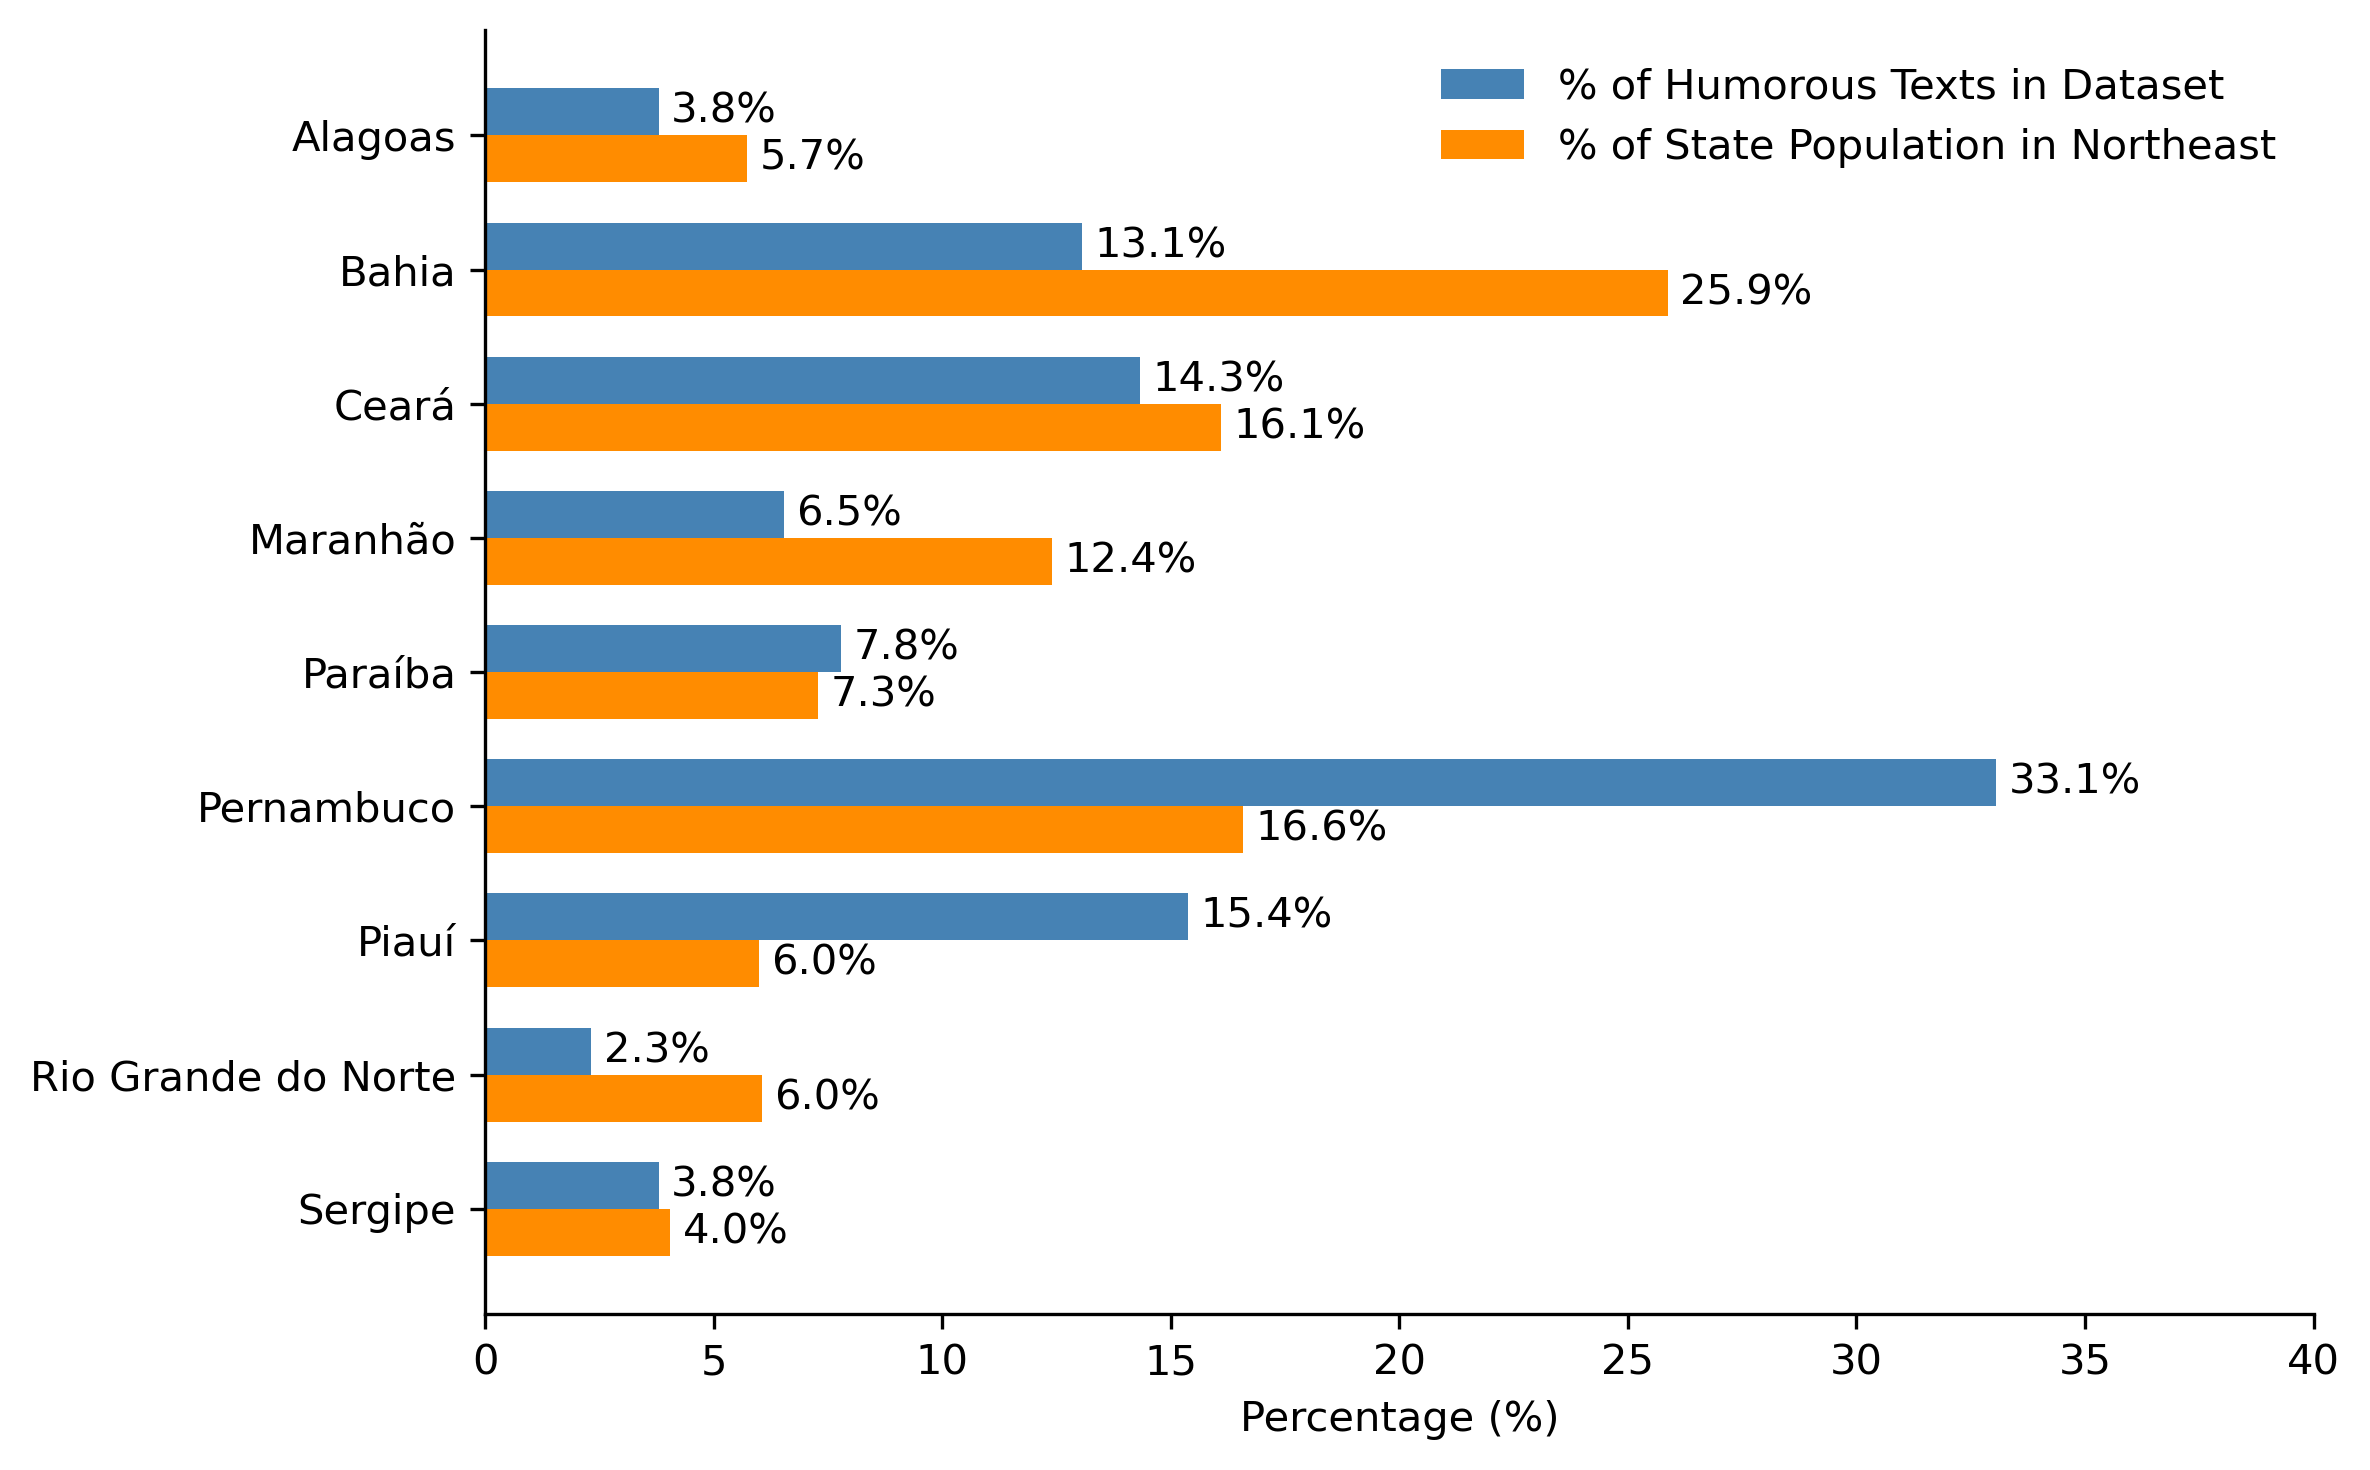

In [18]:
geo_br_northeast_dist = {
    "Bahia": 14136417,
    "Pernambuco": 9058155,
    "Ceará": 8791688,
    "Maranhão": 6775805,
    "Paraíba": 3974687,
    "Rio Grande do Norte": 3302729,
    "Alagoas": 3127683,
    "Piauí": 3271199,
    "Sergipe": 2209558
}

total_population = sum(geo_br_northeast_dist.values())
text_counts = df['brazilian_state'].value_counts()
total_texts = text_counts.sum()

comparison_df = pd.DataFrame({
    'text_count': text_counts,
    'text_percentage': text_counts / total_texts * 100,
    'population': pd.Series(geo_br_northeast_dist)
})

comparison_df['population_percentage'] = comparison_df['population'] / total_population * 100
comparison_df = comparison_df.sort_index()

states = comparison_df.index.tolist()
text_percentages = comparison_df['text_percentage'].values
population_percentages = comparison_df['population_percentage'].values

y = np.arange(len(states))
height = 0.35

fig, ax = plt.subplots(figsize=(8,5), dpi = 300) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

bars1 = ax.barh(y - height/2, text_percentages, height, label='% of Humorous Texts in Dataset', color='steelblue')
bars2 = ax.barh(y + height/2, population_percentages, height, label='% of State Population in Northeast', color='darkorange')

ax.set_xlabel('Percentage (%)')
ax.set_yticks(y)
ax.set_yticklabels(states)
ax.invert_yaxis()
ax.legend(
    loc='upper right',
    frameon=False,
)

def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.1f}%',
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(3, 0),
                    textcoords="offset points",
                    ha='left', va='center')

add_labels(bars1)
add_labels(bars2)

ax.set_xlim(0, 40)
plt.tight_layout()
plt.show()